In [130]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [131]:
train_dir = 'data\\train\\train'
test_dir = 'data\\test\\test'
classes = os.listdir(train_dir)

In [132]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(40),              # resize shortest side
        transforms.CenterCrop(40),          # crop longest side
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [133]:
dataset = ImageFolder(train_dir, transform=train_transform)
testset = ImageFolder(test_dir, transform=train_transform)
print(len(dataset))

18000


In [134]:
def show_image(img,label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  0 (0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


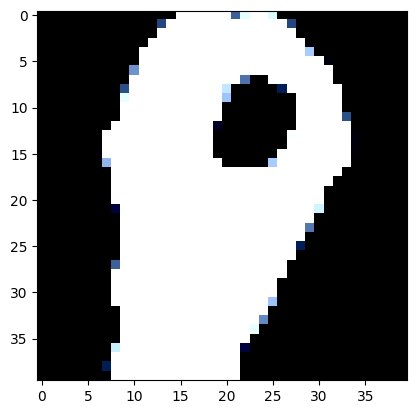

In [135]:
show_image(*dataset[20])

In [136]:
torch.manual_seed(10)
val_size=len(dataset)//5
train_size=len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
test_ds = testset
len(train_ds), len(val_ds), len(test_ds)

(14400, 3600, 6000)

In [137]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)
#data_loader = DataLoader(dataset, batch_size, shuffle=None, num_workers=4, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


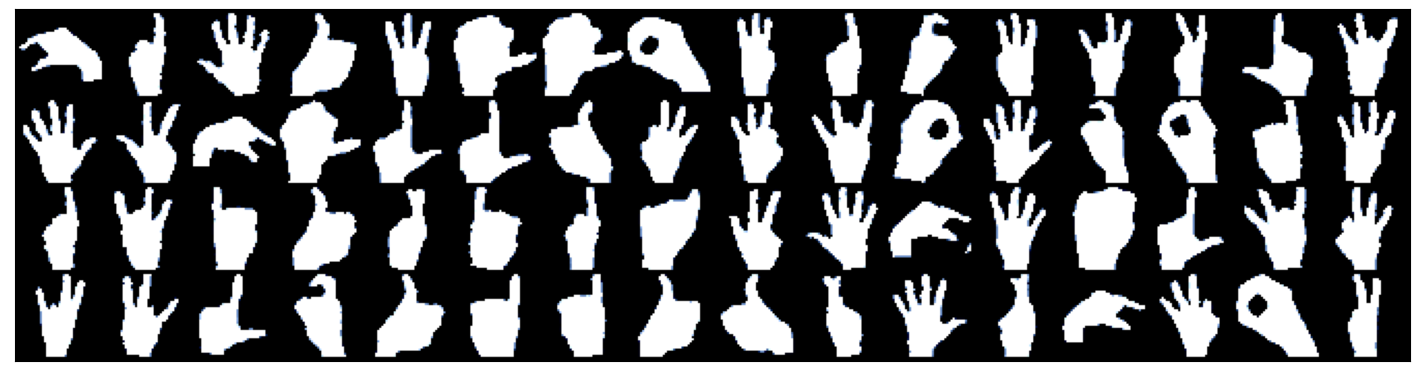

In [138]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

In [139]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [140]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [141]:
torch.cuda.is_available()

True

In [142]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [143]:
device = get_default_device()
device

device(type='cuda')

In [144]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
#data_loader = DeviceDataLoader(data_loader, device)

In [145]:
input_size = 3*40*40
output_size = 3

Conv2d Model

In [146]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [147]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Flatten(), 
            nn.Linear(6250, 256),  
            nn.ReLU(),            
            nn.Linear(256, 128),  
            nn.ReLU(),            
            nn.Linear(128, 64),           
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(32, len(classes)))
        
    def forward(self, xb):
        return self.network(xb)

In [148]:
model = CnnModel()
model.cuda()

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [149]:
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [183]:
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([64, 3, 40, 40])
out.shape: torch.Size([64, 20])
out[0]: tensor([-14.1654,  23.9816, -17.6877,  -4.0062, -19.4078,   2.2745, -18.9243,
        -20.3949,  -6.1967, -15.0818,   0.1886,  -2.9258, -11.9563,  -2.9349,
        -23.9944, -22.7105, -11.9542, -16.8971,  -4.5930,  -5.3637],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [151]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [152]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [153]:
model = to_device(CnnModel(), device)

In [154]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 3.0029566287994385, 'val_acc': 0.05334051698446274}]

In [155]:
num_epochs = 4
opt_func = torch.optim.Adam
lr = 0.001

In [156]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [0], train_loss: 1.3116, val_loss: 0.0157, val_acc: 0.9946


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.1240, val_loss: 0.0024, val_acc: 0.9995


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0641, val_loss: 0.0089, val_acc: 0.9978


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0377, val_loss: 0.0018, val_acc: 0.9995


In [157]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

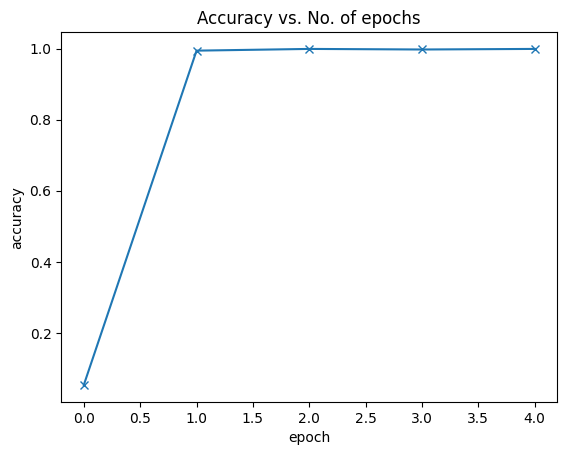

In [158]:
plot_accuracies(history)

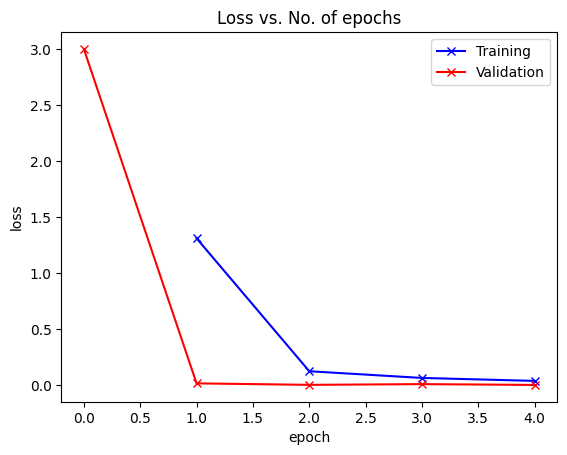

In [159]:
plot_losses(history)

In [160]:
evaluate(model, test_loader)

{'val_loss': 0.11787384003400803, 'val_acc': 0.9804806113243103}

In [169]:
from sklearn.metrics import classification_report

pred = []
Y = []
for i, (x,y) in enumerate(test_loader):
    with torch.no_grad():
        outputs = model(x)
        print(x.shape)
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(classification_report(Y, pred))

torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([128, 3, 40, 40])
torch.Size([12

In [162]:
torch.save(model.state_dict(), "D:\Bac\pythonLok\models\model" + str(num_epochs))

In [205]:
trail = ImageFolder("images\\testing")

trail_transform=transforms.Compose([
        #transforms.Grayscale(num_output_channels=1),
        transforms.Resize(40),              # resize shortest side
        transforms.CenterCrop(40),          # crop longest side
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

trailset = ImageFolder("images\\testing", transform=trail_transform)
print(len(trailset))
#show_image(*trailset[0])

trail_loader = DataLoader(trailset)




4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


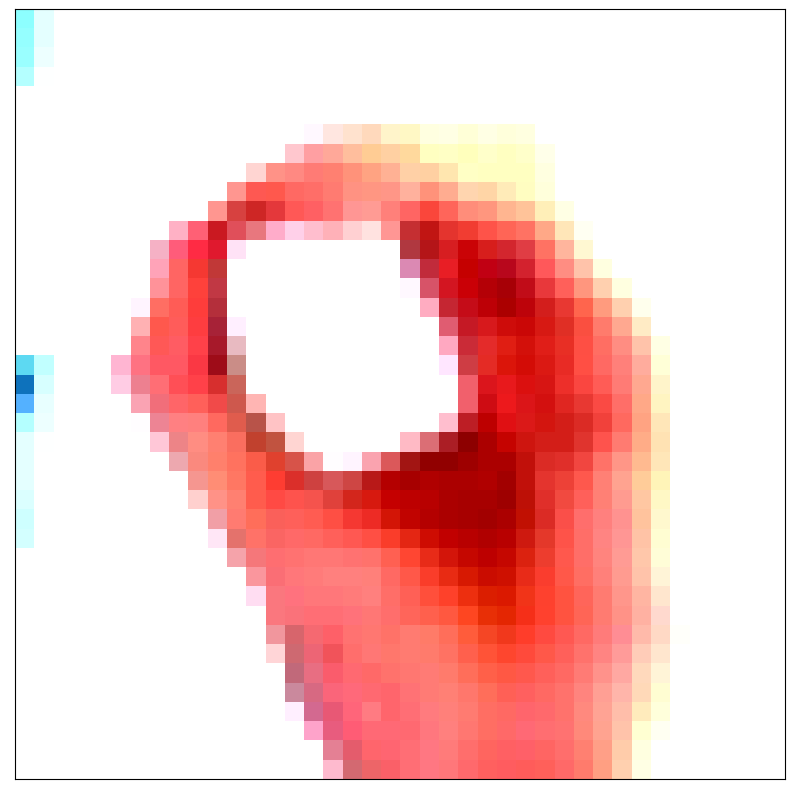

In [206]:
for images, labels in trail_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

trail_loader = DeviceDataLoader(trail_loader,device)

In [207]:
trail_dl = DeviceDataLoader(trail_loader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=6250, out_features=256, bias=True)
    (17): ReLU()
    (18): Linear(in_features

In [208]:
pred = []
Y = []
for i, (x,y) in enumerate(trail_loader):
    with torch.no_grad():
        outputs = model(x)
        
    pred += [int(op.argmax()) for op in outputs]
    Y += [int(yi) for yi in y]

print(pred)

torch.Size([1, 3, 40, 40])
torch.Size([1, 3, 40, 40])
torch.Size([1, 3, 40, 40])
torch.Size([1, 3, 40, 40])
[0, 7, 7, 7]
